# UMMZ Results

In [1]:
import pandas as pd
import numpy as np
import re
import glob
import random
from random import sample
import json
import jsonlines
import pysbd
seg = pysbd.Segmenter(language="en", clean=False) # sentence segmenter
import spacy
from spacy import displacy

In [2]:
custom_ner_model = spacy.load("../../specimen-ner/output/model-best/")

In [3]:
def json2txt_df(json_file_path):
    """
    Extract body text of json file
    """
    with open(json_file_path, 'r') as f:
        data = json.loads(f.read())
        body_text_df = pd.json_normalize(data["pdf_parse"]["body_text"])
    
    return body_text_df

def df2sentences(df):
    """
    Tokenize and clean sentences
    """
    sentences_text = " ".join(list(df.text)) 
    pattern_brackets = re.compile(r'\(.*?\)')
    sentences_text = re.sub(pattern_brackets, "", sentences_text) 
    sentences = seg.segment(sentences_text) 
    sentences = [re.sub(r"^\W+", "", sentence) for sentence in sentences] 
    sentences = [re.sub(r"\s+", " ", sentence) for sentence in sentences]
    return sentences

def prep_data(json_file_path, ref_id):
    """
    Return sentence lists for matches
    """
    body_text_df = json2txt_df(json_file_path)
    sentences = df2sentences(body_text_df)
    candidates = []
    for sentence in sentences:
        doc = nlp(sentence)
        matches = matcher(doc)
        if len(matches) > 0:
            sentence_dict = {"text":sentence,
                             "meta":{"ref_id":str(ref_id)}}
            candidates.append(sentence_dict)    
    return candidates

def clean_text(txt):
    """
    Removes special characters, punctuation, and returns lowercase
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def clean_text2(txt):
    """
    Removes special characters and punctuation
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt))

def alphanum(txt):
    """
    Extracts alphanumeric characters without spaces
    """
    return "".join(x.lower() for x in txt if x.isalnum())

def extract_pat(search_str:str, search_list:str):
    """
    Defines pattern to search for
    """
    search_obj = re.search(search_list, search_str)
    if search_obj:
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = "None"
    return return_str

def extract_ents(text):
    """
    Extract named entities, and beginning, middle and end idx     
    """
    doc = custom_ner_model(text)
    if len(doc.ents) > 0:
        return clean_text2(doc.ents)
    else:
        return None

def predict_ents(df):
    """
    Create new column in data frame with named entity tuple extracted
    """
    df_sent['specimen_prediction'] = df_sent['sent'].apply(extract_ents)

In [4]:
ummz_papers = glob.glob('../../specimen-ner/data/bibliography_ummz_json/*.json')
print(f"Looking for SPECIMEN entities in {len(ummz_papers)} UMMZ papers")

Looking for SPECIMEN entities in 461 UMMZ papers


Find all predictions for all papers

In [31]:
%%time

papers_sample = random.sample(ummz_papers, 1)

for file in papers_sample:
    ref_id = file.split("/")[-1].split("-")[0]
    print(f"Searching for SPECIMEN entities in paper: {ref_id}")
    body_text_df = json2txt_df(file)
    sentence_list = df2sentences(body_text_df)
    for sentence in sentence_list:
        clean_sent = clean_text2(sentence)
        doc = custom_ner_model(clean_sent)
        if len(doc.ents) > 0:
            displacy.render(doc, style="ent", jupyter=True)

Searching for SPECIMEN entities in paper: Hooper1944


CPU times: user 1.67 s, sys: 971 µs, total: 1.67 s
Wall time: 3.34 s


Total times mentioned across corpus

In [32]:
%%time

df_test_pubs = pd.DataFrame()
for test_file in ummz_papers:
    with open(test_file, 'r') as f:
        data = json.loads(f.read())
        file_data = pd.json_normalize(data["pdf_parse"]["body_text"])
        file_data["paper_id"] = data["title"]
    df_test_pubs = pd.concat([df_test_pubs, file_data])

ummz_sentences = []

for row in df_test_pubs.itertuples():
    for sent in seg.segment(row[1]):
        ummz_sentences.append((row[7], row[5], row[7], sent))
        
df_sent = pd.DataFrame(ummz_sentences, columns=['Id', 'section_title', 'paper_title', 'sent'])
df_sent['sent'] = df_sent['sent'].astype(str)
df_sent
    
predict_ents(df_sent)

df_sent['specimen_prediction'].value_counts().sort_values(ascending=False)

CPU times: user 2h 58min 18s, sys: 16.6 s, total: 2h 58min 34s
Wall time: 3h 36min 30s


 GSP UM 3551                                         15
 YB 10                                               12
 EME PV 313                                          11
 AMNH 267597                                          8
 UFPE 427                                             8
                                                     ..
 UMMZ 117898 UMMZ 118632 UMMZ 117911 UMMZ 118339      1
 IUCN 2012a                                           1
 USNM 172985                                          1
 lnL 22504 lnL 22490                                  1
 PWK Y                                                1
Name: specimen_prediction, Length: 1196, dtype: int64

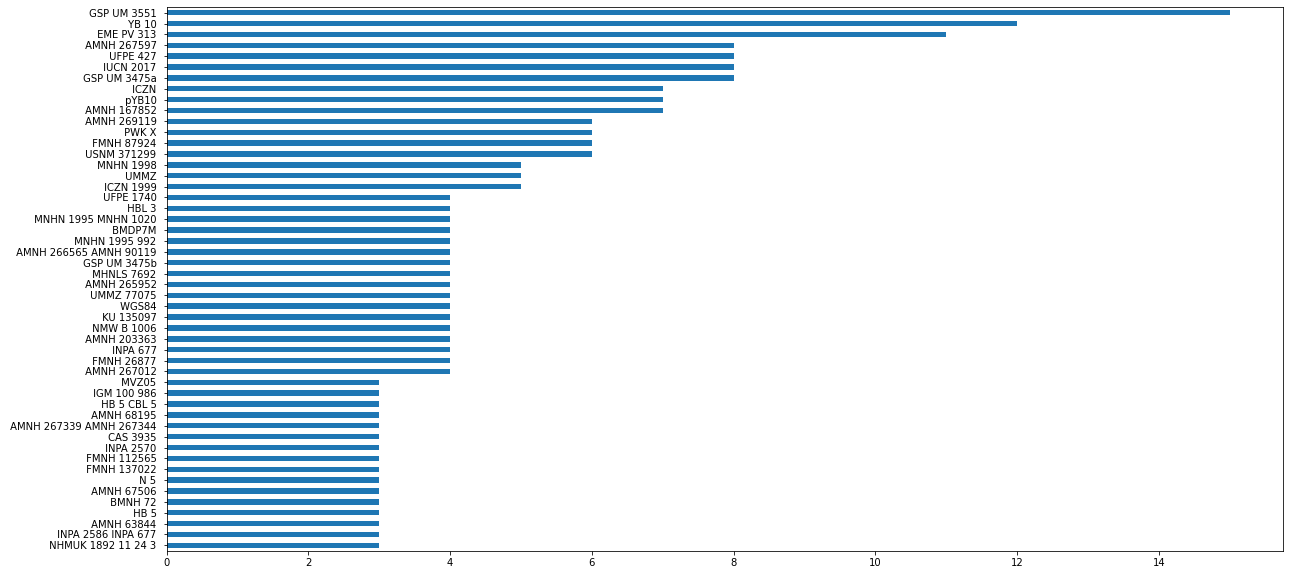

In [39]:
import matplotlib.pyplot as plt

fig = df_sent['specimen_prediction'].value_counts().nlargest(50).sort_values().plot(kind='barh',figsize=(20,10))
plt.savefig('../../specimen-ner/results/ummz_specimen_count.png', dpi=500)

In [35]:
ummz_unique_codes = set(df_sent['specimen_prediction'].unique())
len(ummz_unique_codes)

1197

In [37]:
predictions_ummz = df_sent[df_sent.specimen_prediction.notna()]
predictions_ummz = predictions_ummz[predictions_ummz.Id.notna()]
predictions_ummz['paper'] = predictions_ummz['Id'].astype("category").cat.codes

predictions_ummz['Id'] = predictions_ummz[['Id','paper','specimen_prediction']].groupby(['specimen_prediction','paper'])['Id'].transform(lambda x: ','.join(x))
predictions_ummz.to_csv('../../specimen-ner/results/predictions_ummz.csv',index=False)

predictions_ummz_dedup = predictions_ummz[['specimen_prediction','Id','paper']].drop_duplicates()
predictions_ummz_dedup.to_csv('../../specimen-ner/results/specimens_per_paper_ummz.csv')

In [38]:
cross_df = pd.crosstab(predictions_ummz_dedup.specimen_prediction, predictions_ummz_dedup.paper, margins=True, dropna=False)
cross_df.to_csv('../../specimen-ner/results/frequency_ummz.csv')
cross_df

paper,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,All
specimen_prediction,,,,,,,,,,,,,,,,,,,,,
2N 28 MNHN 1972 MNHN 639 MNHN 263 MNHN 266 MNHN 36 MNHN 1983 MNHN 376,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
A AY243413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
A M AK11525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AA AT AA AT AA AT AA AT ZISP AA AT AA AT AA AT 71 AA AT AA AT 103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AAAS 1991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
peM 77 05397 DEB 77 06706,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
specimens AMNH 95206 USNM 194785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
vWF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
